<img src="https://www.alura.com.br/artigos/assets/para-que-serve-adobe-illustrator/imagem1.jpg" alt="Imagem1.png" width="300" />


# **Redes Neurais Difusoras: Deep Learning com Pytorch**
---



## **Aula 07 - Difusão Condicional com Rótulos**

Nas aulas anteriores, contruimos um modelos de difusão de forma completa, passando pelos fundamental da U-Net com seus blocos residuais e conexões skip. Agora chegamos a um dos aspectos mavançados dos modelos de difusão que é o condicionamento.

O condicionamento transforma nossos modelos de geradores aleatórios em ferramentas mais precisas e de síntese controlada. Enquanto nossa rede neural anterior gerava imagens aleatórias, caso não tivessemos filtrado a base de dados, agora ela será capaz de gerar imagens específicas baseadas em critérios que definirmos, como a classe do objeto ou características espaciais.

### **Classifier-Free Guidance**

Para entender bem sobre o Condicionamento é crucial entender o conceito de [Classifier-Free Guidance](https://medium.com/@baicenxiao/understand-classifier-guidance-and-classifier-free-guidance-in-diffusion-model-via-python-e92c0c46ec18). Esta técnica é o pilar inicial para eliminar a necessidade de treinar classificadores externos para guiar a geração. A ideia central é treinar um único modelo que opera tanto condicionalmente quanto incondicionalmente, combinando as predições durante a inferência para obter controle fino sobre a geração.

Implementaremos na Aula 07 e 08 as duas modalidades principais: **condicionamento por rótulos **(que permite especificar qual classe queremos gerar) e **condicionamento espacia**l (que controla estruturas geométricas da imagem).

## **Configurações iniciais**

Começamos com as importações e configuração do ambiente. Aqui também está incluído o código (comentado) para download do dataset de imagens de ressonância magnética cerebral que usaremos para treinar e visualizar o comportamento da rede.

In [ ]:
!pip install torchview -q

In [ ]:
# Bibliotecas padrão
import re
import ast
import math
import numpy as np
import textwrap
import kagglehub
import shutil
import os
import pandas as pd
from collections import defaultdict, Counter

# Bibliotecas de visualização
import imageio
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Image as Im2

# Bibliotecas PyTorch, torchvision, estatisticas e Visão Computacional
import cv2
import torch.nn as nn
import torch, torch.nn.functional as F
from torch.amp import GradScaler, autocast
from torch.utils.data import random_split
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils import clip_grad_norm_

from torchview import draw_graph
from torchvision.utils import make_grid
from torchvision.transforms import v2

import torchvision
import torchvision.transforms as transforms

from tqdm.auto import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
# Baixar dataset
dataset_path = kagglehub.dataset_download("ashfakyeafi/brain-mri-images")

# Definir destino no /content
destination_path = '/content/brain-mri-images'

# Copiar para /content
shutil.copytree(dataset_path, destination_path, dirs_exist_ok=True)
print("Dataset copiado para:", destination_path)

100%|██████████| 348M/348M [00:15<00:00, 23.1MB/s]

Extracting files...


Dataset copiado para: /content/brain-mri-images


Agora vamos definir a classe do dataset que utilizaremos para treinar nossa U-Net condicional. Escolhemos imagens de ressonância magnética cerebral por apresentarem características visuais distintas entre diferentes planos de corte. Este dataset vamos extrair como na aula anterior os rótulos dos nomes dos arquivos e armazenalos como labels.

In [ ]:
class Dataset(Dataset):
    def __init__(self, images_dir, transform=None, slice_plane=None):
        self.transform = transform
        self.slice_plane = slice_plane
        self.image_files = []
        self.labels = []
        self.label_to_idx = {}

        for root, _, files in os.walk(images_dir):
            for file in files:
                if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
                    parts = file.lower().split('_')
                    if len(parts) > 3:
                        plane = parts[3]
                        self.image_files.append(os.path.join(root, file))

                        label = plane  # Usando o plano como rótulo
                        if label not in self.label_to_idx:
                            self.label_to_idx[label] = len(self.label_to_idx)
                        self.labels.append(self.label_to_idx[label])

        self.idx_to_label = {v: k for k, v in self.label_to_idx.items()}
        self.num_classes = len(self.label_to_idx)

        print(f"Dataset carregado: {len(self.image_files)} imagens")
        print(f"Classes encontradas: {self.label_to_idx}")

        # Impressão da quantidade de amostras por classe (rótulo original)
        label_counts = Counter(self.labels)
        for idx, count in label_counts.items():
            print(f"Classe '{self.idx_to_label[idx]}': {count} amostras")

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        img_name = os.path.basename(img_path).lower()
        image = Image.open(img_path).convert('L')

        parts = img_name.split('_')
        slice_plane = parts[3]

        if self.transform:
            image = self.transform(image)

        return {
            "image": image,
            "slice": slice_plane,
            "label": self.labels[idx]
        }


Com o dataset pronto, definimos o pipeline de transformação, como redimensionamento e normalização, e instanciamos o DataLoader. Isso garantirá que tenhamos batches preparados para o treinamento da rede posteriormente.

In [ ]:
# Definir Dimensão da Imagem
img_size = 64

# Transformação básica para normalizar para [-1,1]
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
# Dataset e DataLoader
dataset = Dataset(
    '/content/brain-mri-images',
    transform=transform,
    slice_plane=None
    )

# Carrega dataset
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

Dataset carregado: 7692 imagens
Classes encontradas: {'z': 0, 'y': 1, 'x': 2}
Classe 'z': 2564 amostras
Classe 'y': 2564 amostras
Classe 'x': 2564 amostras


Visualizando 16 amostras do dataset


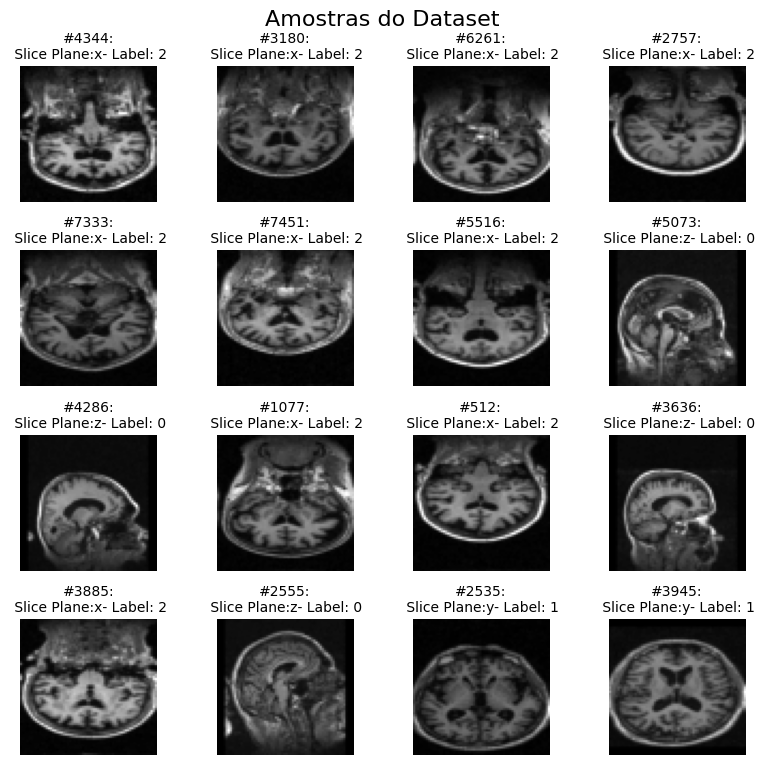

In [ ]:
# Seleciona aleatoriamente até 16 índices do dataset
indices = np.random.choice(len(dataset), size=min(16, len(dataset)), replace=False)
print(f"Visualizando {len(indices)} amostras do dataset")

# Define grid para exibição: 8 colunas e número de linhas necessário
cols = 4
rows = (len(indices) + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(8, 2 * rows))

# Garante que axes tenha sempre shape 2D para facilitar o loop
axes = np.atleast_2d(axes)

# Itera sobre cada índice selecionado e plota no grid
for i, idx in enumerate(indices):
    row, col = divmod(i, cols)
    ax = axes[row, col]

    sample = dataset[idx]

    # Recupera imagem e label
    image = sample['image']
    slice_plane = sample['slice']
    label = sample['label']

    # Desnormaliza de [-1,1] para [0,1]
    img_vis = torch.clamp((image * 0.5) + 0.5, 0, 1)
    img_np = img_vis.permute(1, 2, 0).cpu().numpy()

    # Plota a imagem
    ax.imshow(img_np, cmap='gray')
    ax.axis('off')

    # Formata o texto do label em múltiplas linhas
    slice_plane = "\n".join(textwrap.wrap(str(slice_plane), width=10))
    ax.set_title(f"#{idx}:\n Slice Plane:{slice_plane}- Label: {label}", fontsize=10, pad=5)

# Oculta subplots vazios
total_slots = rows * cols
for i in range(len(indices), total_slots):
    row, col = divmod(i, cols)
    axes[row, col].axis('off')

# Título geral do grid
plt.suptitle("Amostras do Dataset", fontsize=16, y=0.95)
plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.show()

## **Arquitetura Condicional por Rótulo**

Agora evoluímos nossa arquitetura U-Net para incorporar informações condicionais. O primeiro componente fundamental é o sistema de embeddings que converte rótulos discretos em representações contínuas que nossa rede neural pode processar eficientemente.

### **Embedding de Rótulos ( [Label Embedding](http://scikit.ml/multilabelembeddings.html))**

Esta camada de embedding é crucial porque transforma índices categóricos (0, 1, 2 para nossos planos de corte) em vetores densos que capturam relações semânticas entre as classes. É similar ao que se faz com embeddings de palavras em NLP, mas aplicado a classes de imagens.

In [ ]:
class LabelEmbedding(nn.Module):
    def __init__(self, num_classes, embed_dim):
        super().__init__()
        self.embedding = nn.Embedding(num_classes, embed_dim)
        self.num_classes = num_classes

    def forward(self, labels):
        return self.embedding(labels)

### **Embedding temporal**

Recordando das aulas anteriores, nosso embedding temporal já permitia que a rede entendesse em qual passo do processo de difusão ela estava. Agora expandimos esta funcionalidade para também incorporar informações de rótulo.

In [ ]:
# Embedding senoidal de tempo
def sinusoidal_embedding(t, dim):
    half = dim // 2
    freqs = torch.exp(-math.log(10000) * torch.arange(half, device=t.device,
                                                      dtype=torch.float32) / (half - 1))
    emb = t[:, None].float() * freqs[None, :]
    return torch.cat([emb.sin(), emb.cos()], dim=1)

In [ ]:
class ConditionalTimeEmbedding(nn.Module):
    def __init__(self, time_dim, label_dim):
        super().__init__()
        self.time_dim = time_dim
        self.label_dim = label_dim

        # MLP para processar embedding temporal
        self.time_mlp = nn.Sequential(
            nn.Linear(time_dim, time_dim * 4),
            nn.SiLU(),
            nn.Linear(time_dim * 4, time_dim)
        )

        # MLP para processar embedding de rótulo
        self.label_mlp = nn.Sequential(
            nn.Linear(label_dim, label_dim * 2),
            nn.SiLU(),
            nn.Linear(label_dim * 2, time_dim)
        )

        # Camada de fusão
        self.fusion = nn.Sequential(
            nn.Linear(time_dim * 2, time_dim),
            nn.SiLU()
        )

    def forward(self, t, label_emb):
        # Processar embedding temporal
        t_emb = sinusoidal_embedding(t, self.time_dim)
        t_emb = self.time_mlp(t_emb)

        # Processar embedding de rótulo
        l_emb = self.label_mlp(label_emb)

        # Fusão dos embeddings
        combined = torch.cat([t_emb, l_emb], dim=1)
        return self.fusion(combined)

### **Bloco Residual Condicional**

Evoluindo nossos blocos residuais das aulas anteriores, agora injetamos informação condicional diretamente nas ativações através de projeções lineares. Esse condicionamento permite que a rede adapte seu comportamento conforme a entrada auxiliar, sendo ideal para modelos de difusão e geração condicionada. A normalização com `GroupNorm` e o uso de `SiLU`, `dropout` e `conexão residual` garantem estabilidade da rede.

In [ ]:
class ConditionalResidualBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim, groups=8, dropout=0.1):
        super().__init__()
        self.same_channels = (in_ch == out_ch)

        # Primeira convolução
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(groups, out_ch)
        self.act1 = nn.SiLU()

        # Projeção do embedding condicional
        self.time_proj = nn.Linear(time_dim, out_ch)

        # Segunda convolução
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(groups, out_ch)
        self.act2 = nn.SiLU()

        # Dropout para regularização
        self.dropout = nn.Dropout(dropout)

        # Skip connection
        self.skip = nn.Conv2d(in_ch, out_ch, kernel_size=1) if not self.same_channels else nn.Identity()

    def forward(self, x, cond_emb):
        residual = self.skip(x)

        # Primeira convolução
        h = self.conv1(x)
        h = self.norm1(h)
        h = self.act1(h)

        # Adicionar condicionamento
        cond = self.time_proj(cond_emb)[:, :, None, None]
        h = h + cond

        # Segunda convolução
        h = self.conv2(h)
        h = self.norm2(h)
        h = self.dropout(h)
        h = self.act2(h)

        # Conexão residual
        return (h + residual) / 1.414

### **Módulos Down e Up Condicionais**

Ainda nessa aula mantemos a estrutura hierárquica da U-Net que aprendemos nas aulas anteriores, mas agora todos os blocos residuais recebem informação condicional.

In [ ]:
class ConditionalDown(nn.Module):
    def __init__(self, in_ch, out_ch, time_dim):
        super().__init__()
        self.block1 = ConditionalResidualBlock(in_ch, out_ch, time_dim)
        self.block2 = ConditionalResidualBlock(out_ch, out_ch, time_dim)
        self.pool = nn.Conv2d(out_ch, out_ch, kernel_size=4, stride=2, padding=1)

    def forward(self, x, cond_emb):
        x = self.block1(x, cond_emb)
        x = self.block2(x, cond_emb)
        p = self.pool(x)
        return x, p

class ConditionalUp(nn.Module):
    def __init__(self, in_ch, skip_ch, out_ch, time_dim):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=4, stride=2, padding=1)
        self.block1 = ConditionalResidualBlock(out_ch + skip_ch, out_ch, time_dim)
        self.block2 = ConditionalResidualBlock(out_ch, out_ch, time_dim)

    def forward(self, x, skip, cond_emb):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        x = self.block1(x, cond_emb)
        x = self.block2(x, cond_emb)
        return x

### **Classe Final**

Integramos todos os módulos anteriores em uma arquitetura. Observe que o `bottleneck` profundo entre as fases de down e upsampling, essencial para processamento global da imagem condicionada. A camada de saída usa `Conv2d` para retornar uma imagem com o mesmo número de canais que a entrada.

In [ ]:
class ConditionalUNet(nn.Module):
    def __init__(self, in_channels=1, base_channels=64, num_classes=1,
                 time_dim=256, label_dim=128, dropout_prob=0.1):
        super().__init__()

        self.num_classes = num_classes
        self.dropout_prob = dropout_prob

        # Embedding de rótulos
        self.label_embedding = LabelEmbedding(num_classes, label_dim)

        # Embedding temporal condicional
        self.time_embedding = ConditionalTimeEmbedding(time_dim, label_dim)

        # Encoder (downsampling)
        self.down1 = ConditionalDown(in_channels, base_channels, time_dim)
        self.down2 = ConditionalDown(base_channels, base_channels * 2, time_dim)
        self.down3 = ConditionalDown(base_channels * 2, base_channels * 4, time_dim)
        self.down4 = ConditionalDown(base_channels * 4, base_channels * 8, time_dim)

        # Bottleneck
        self.bot1 = ConditionalResidualBlock(base_channels * 8, base_channels * 16, time_dim)
        self.bot2 = ConditionalResidualBlock(base_channels * 16, base_channels * 8, time_dim)

        # Decoder (upsampling)
        self.up4 = ConditionalUp(base_channels * 8, base_channels * 8, base_channels * 4, time_dim)
        self.up3 = ConditionalUp(base_channels * 4, base_channels * 4, base_channels * 2, time_dim)
        self.up2 = ConditionalUp(base_channels * 2, base_channels * 2, base_channels, time_dim)
        self.up1 = ConditionalUp(base_channels, base_channels, base_channels, time_dim)

        # Camada de saída
        self.out = nn.Conv2d(base_channels, in_channels, kernel_size=1)

    def forward(self, x, t, labels=None):
        # Embedding de rótulos (com classifier-free guidance)
        if labels is not None:
            # Durante o treinamento, dropout algumas labels para classifier-free guidance
            if self.training:
                # Mask para dropout
                mask = torch.rand(labels.shape[0], device=labels.device) < self.dropout_prob
                labels = labels.clone()
                labels[mask] = self.num_classes - 1

            label_emb = self.label_embedding(labels)
        else:
            # Inferência sem condição
            label_emb = torch.zeros(x.shape[0], self.label_embedding.embedding.embedding_dim, device=x.device)

        # Embedding temporal condicional
        cond_emb = self.time_embedding(t, label_emb)

        # Encoder
        s1, p1 = self.down1(x, cond_emb)
        s2, p2 = self.down2(p1, cond_emb)
        s3, p3 = self.down3(p2, cond_emb)
        s4, p4 = self.down4(p3, cond_emb)

        # Bottleneck
        b = self.bot1(p4, cond_emb)
        b = self.bot2(b, cond_emb)

        # Decoder
        u4 = self.up4(b, s4, cond_emb)
        u3 = self.up3(u4, s3, cond_emb)
        u2 = self.up2(u3, s2, cond_emb)
        u1 = self.up1(u2, s1, cond_emb)

        return self.out(u1)

### **Visualização Estrutural com Torchview**

Utilizando a biblioteca `torchview`, visualizamos o grafo computacional da nossa rede neural. Esta visualização nos ajuda a confirmar que a arquitetura foi implementada corretamente e a entender o fluxo de informações através da rede.

In [ ]:
# Definir Modelo e otimizador
model = ConditionalUNet(
    in_channels=1,
    base_channels=64,
    num_classes=dataset.num_classes + 1,  # +1 para classe "sem condição"
    time_dim=256,
    label_dim=128,
    dropout_prob=0.1
).to(device)

opt = torch.optim.AdamW(model.parameters(), lr=1e-4)

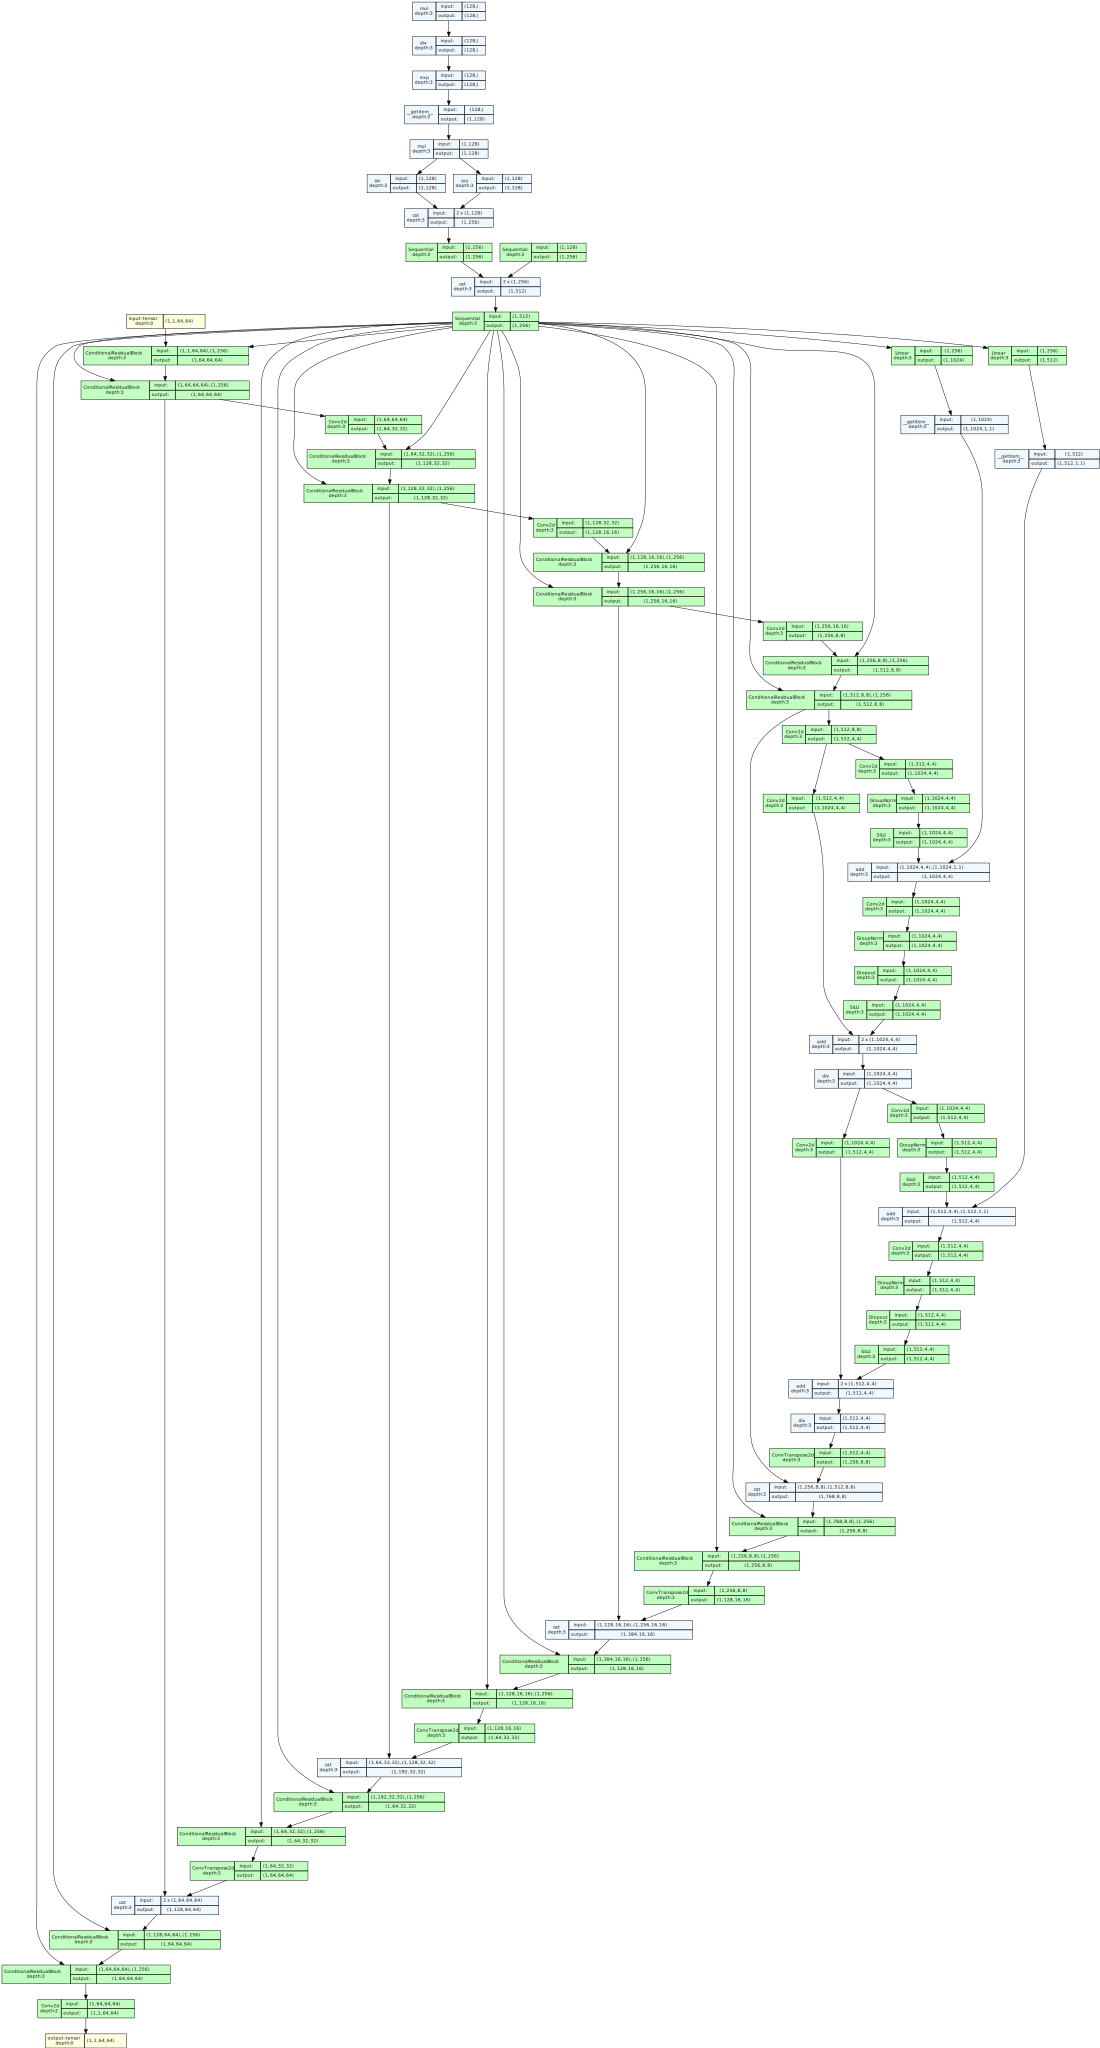

In [ ]:
## extrai um batch do seu dataloader
batch = next(iter(dataloader))
x_sample = batch['image'].to(device)

# Pegar um batch pequeno
x_sample = x_sample[:1]

# Criar uma classe para fixar o timestep
class WrappedUNet(nn.Module):
    def __init__(self, unet):
        super().__init__()
        self.unet = unet
    def forward(self, x):
        t = torch.tensor([500], device=x.device)  # timestep fixo
        return self.unet(x, t)

wrapped_model = WrappedUNet(model)

# Desenhar o diagrama
graph = draw_graph(wrapped_model,
                   input_data=x_sample,
                   graph_name="U-Net Conditional",
                   roll=True)
graph.visual_graph

### **Parâmetros do Processo de Difusão**

Retomamos os conceitos fundamentais das aulas anteriores sobre o cronograma de ruído (noise schedule). Nossa agenda de β values segue a mesma formulação DDPM que implementamos anteriormente.

In [ ]:
# Parâmetros do processo de difusão
T = 1000
beta_start, beta_end = 1e-4, 0.02

# Schedule de beta
betas = torch.linspace(beta_start, beta_end, T).to(device)
alphas = 1.0 - betas
alpha_bar = torch.cumprod(alphas, 0)

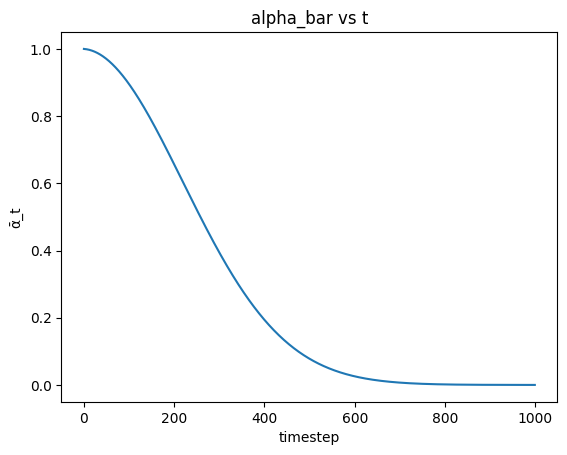

In [ ]:
# Visualizar alpha acumulado
plt.plot(alpha_bar.cpu())
plt.title("alpha_bar vs t")
plt.xlabel("timestep")
plt.ylabel("ᾱ_t")
plt.show()

#### **Forward Process (q_sample)**

Nossa função `q_sample` permanece matematicamente idêntica às aulas anteriores, implementando a distribuição `q(x_t | x_0)`. O condicionamento não altera o processo forward, apenas influencia como a rede aprende a reverter esse processo.

In [ ]:
def q_sample(x0, t, noise):
    t = t.to(x0.device)

    # Extrai sqrt(ᾱ_t) para cada t do batch e adiciona dimensões extras
    sqrt_alpha_bar_t = torch.sqrt(alpha_bar[t]).view(-1, 1, 1, 1)

    # Extrai sqrt(1 - ᾱ_t) de mesmo modo
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar[t]).view(-1, 1, 1, 1)

    # Retorna sqrt(ᾱ_t) * x0 + sqrt(1 - ᾱ_t) * noise (distribuição q(x_t | x_0))
    return sqrt_alpha_bar_t * x0 + sqrt_one_minus_alpha_bar_t * noise

#### **Reverse Process (p_sample_ddpm)**

Entretanto o processo reverso agora incorpora `Classifier-Free Guidance`, fazendo duas predições (condicional e incondicional).

O parâmetro `guidance_scale` nos permite controlar o quão fortemente seguimos a condição. Valores maiores produzem amostras mais fiéis à classe especificada, mas podem reduzir diversidades.

In [ ]:
@torch.no_grad()
def p_sample_conditional(model, x, t, labels, guidance_scale=1.0):
    B = x.shape[0]
    t_tensor = torch.full((B,), t, device=device, dtype=torch.long)

    # Predição condicional
    pred_noise_cond = model(x, t_tensor, labels)

    # Predição incondicional (usando classe especial)
    uncond_labels = torch.full_like(labels, model.num_classes - 1)
    pred_noise_uncond = model(x, t_tensor, uncond_labels)

    # Classifier-free guidance
    pred_noise = pred_noise_uncond + guidance_scale * (pred_noise_cond - pred_noise_uncond)

    # Parâmetros do processo reverso
    beta_t = betas[t]
    alpha_t = alphas[t]
    alpha_bar_t = alpha_bar[t]

    # Média do posterior
    coeff1 = 1 / torch.sqrt(alpha_t)
    coeff2 = beta_t / torch.sqrt(1 - alpha_bar_t)
    mean = coeff1 * (x - coeff2 * pred_noise)

    # Adição de ruído (exceto no último passo)
    if t > 0:
        alpha_bar_prev = alpha_bar[t-1] if t > 0 else torch.tensor(1.0)
        posterior_variance = beta_t * (1 - alpha_bar_prev) / (1 - alpha_bar_t)
        noise = torch.randn_like(x)
        x_prev = mean + torch.sqrt(posterior_variance) * noise
    else:
        x_prev = mean

    return x_prev

### **Experimentos**

#### **Treinamento do Modelo**

Agora vamos iniciar o treinamento do modelo. Podemos incorporar uma função que gere imagens durante o processo, permitindo visualizarmos a evolução do modelo ao longo do tempo, assim como fizemos na aula passada.

In [ ]:
# Função para mostrar progresso com geração
def show_and_predict_conditional(model, labels, T, epoch=None):
    model.eval()

    # Inicializar com ruído
    x = torch.randn(1, 1, img_size, img_size, device=device)

    # Processo reverso
    for t in reversed(range(T)):
        x = p_sample_conditional(model, x, t, labels, guidance_scale=3.0)

    # Processar imagem
    img = (x.clamp(-1, 1) + 1) / 2
    img = img[0].permute(1, 2, 0).cpu().numpy()
    img = (img * 255).astype('uint8')

    # Visualizar
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(img, cmap='gray')
    ax.axis('off')

    if epoch is not None:
        class_name = dataset.idx_to_label[labels[0].item()]
        ax.text(2, 8, f"Época {epoch}", fontsize=12, color='white',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='red', alpha=0.9))
        ax.text(2, img_size-8, f"Classe: {class_name}", fontsize=10, color='white',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='blue', alpha=0.9))

    plt.tight_layout()
    plt.show()

    return img

Vamos implementar também uma função de perda que mantém a simplicidade da formulação original do DDPM, o erro quadrático médio (MSE) entre o ruído real e o ruído predito, mas agora com a predição condicionada ao rótulo da classe.

In [ ]:
def conditional_loss_fn(model, x0, labels, t):
    B = x0.shape[0]

    # Ruído aleatório
    noise = torch.randn_like(x0)

    # Amostra ruidosa
    x_t = q_sample(x0, t, noise)

    # Predição do modelo
    pred_noise = model(x_t, t, labels)

    # MSE Loss
    loss = F.mse_loss(pred_noise, noise)

    return loss

Implementamos um loop de treinamento que gera visualizações periódicas do progresso, permitindo acompanhar como o condicionamento melhora ao longo das épocas.

Iniciando treinamento condicional por 100 épocas...


Épocas:   0%|          | 0/100 [00:00<?, ?it/s]

Época 1:   0%|          | 0/61 [00:00<?, ?it/s]

Época 0, Perda: 0.1869


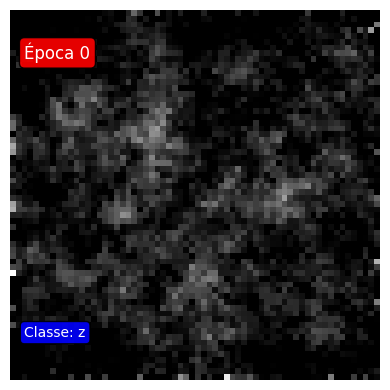

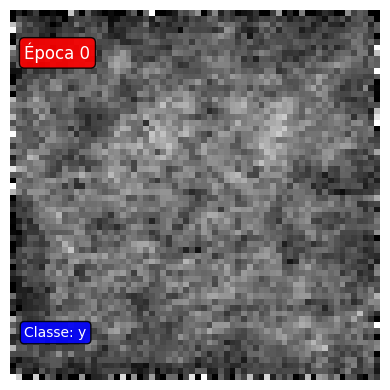

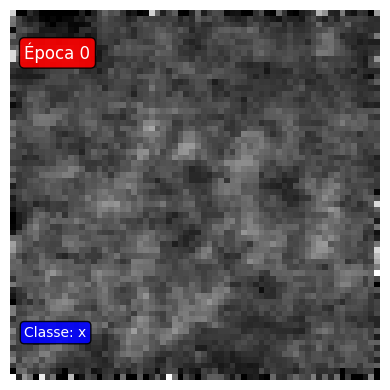

Época 2:   0%|          | 0/61 [00:00<?, ?it/s]

Época 3:   0%|          | 0/61 [00:00<?, ?it/s]

Época 4:   0%|          | 0/61 [00:00<?, ?it/s]

Época 5:   0%|          | 0/61 [00:00<?, ?it/s]

Época 6:   0%|          | 0/61 [00:00<?, ?it/s]

Época 7:   0%|          | 0/61 [00:00<?, ?it/s]

Época 8:   0%|          | 0/61 [00:00<?, ?it/s]

Época 9:   0%|          | 0/61 [00:00<?, ?it/s]

Época 10:   0%|          | 0/61 [00:00<?, ?it/s]

Época 11:   0%|          | 0/61 [00:00<?, ?it/s]

Época 10, Perda: 0.0308


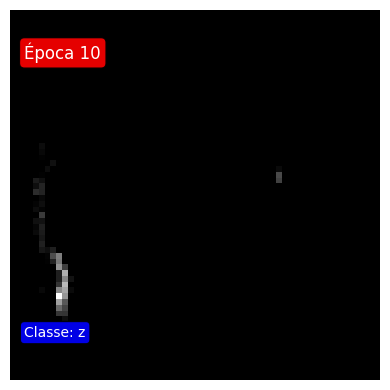

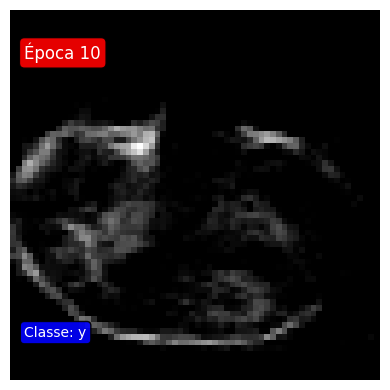

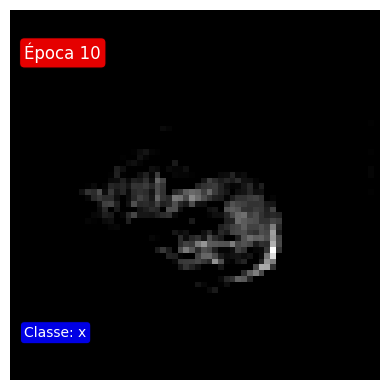

Época 12:   0%|          | 0/61 [00:00<?, ?it/s]

Época 13:   0%|          | 0/61 [00:00<?, ?it/s]

Época 14:   0%|          | 0/61 [00:00<?, ?it/s]

Época 15:   0%|          | 0/61 [00:00<?, ?it/s]

Época 16:   0%|          | 0/61 [00:00<?, ?it/s]

Época 17:   0%|          | 0/61 [00:00<?, ?it/s]

Época 18:   0%|          | 0/61 [00:00<?, ?it/s]

Época 19:   0%|          | 0/61 [00:00<?, ?it/s]

Época 20:   0%|          | 0/61 [00:00<?, ?it/s]

Época 21:   0%|          | 0/61 [00:00<?, ?it/s]

Época 20, Perda: 0.0260


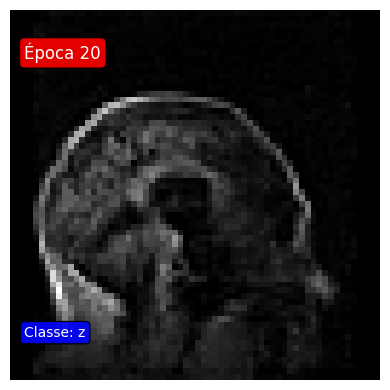

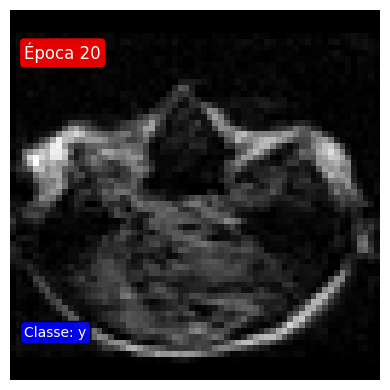

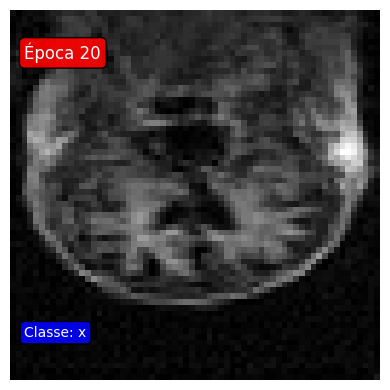

Época 22:   0%|          | 0/61 [00:00<?, ?it/s]

Época 23:   0%|          | 0/61 [00:00<?, ?it/s]

Época 24:   0%|          | 0/61 [00:00<?, ?it/s]

Época 25:   0%|          | 0/61 [00:00<?, ?it/s]

Época 26:   0%|          | 0/61 [00:00<?, ?it/s]

Época 27:   0%|          | 0/61 [00:00<?, ?it/s]

Época 28:   0%|          | 0/61 [00:00<?, ?it/s]

Época 29:   0%|          | 0/61 [00:00<?, ?it/s]

Época 30:   0%|          | 0/61 [00:00<?, ?it/s]

Época 31:   0%|          | 0/61 [00:00<?, ?it/s]

Época 30, Perda: 0.0269


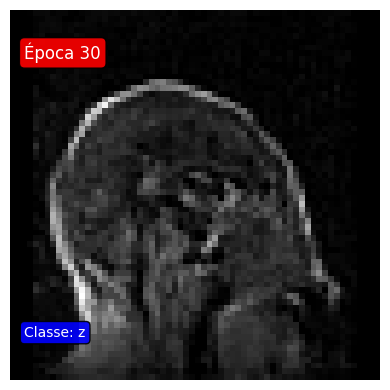

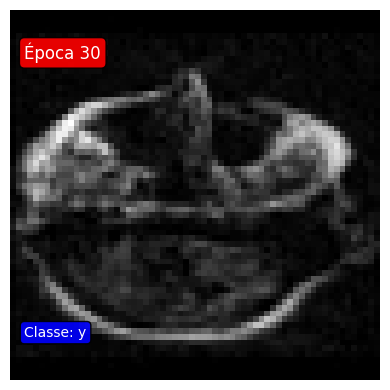

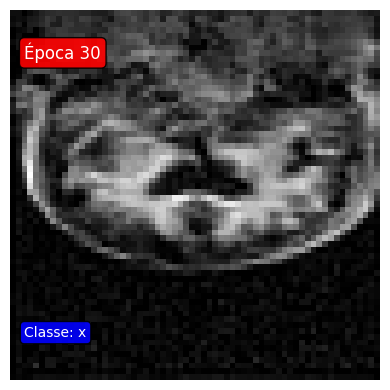

Época 32:   0%|          | 0/61 [00:00<?, ?it/s]

Época 33:   0%|          | 0/61 [00:00<?, ?it/s]

Época 34:   0%|          | 0/61 [00:00<?, ?it/s]

Época 35:   0%|          | 0/61 [00:00<?, ?it/s]

Época 36:   0%|          | 0/61 [00:00<?, ?it/s]

Época 37:   0%|          | 0/61 [00:00<?, ?it/s]

Época 38:   0%|          | 0/61 [00:00<?, ?it/s]

Época 39:   0%|          | 0/61 [00:00<?, ?it/s]

Época 40:   0%|          | 0/61 [00:00<?, ?it/s]

Época 41:   0%|          | 0/61 [00:00<?, ?it/s]

Época 40, Perda: 0.0248


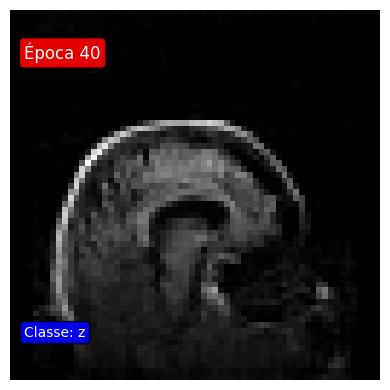

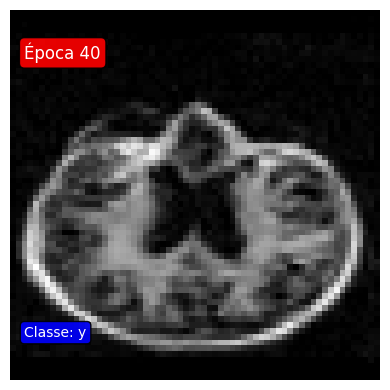

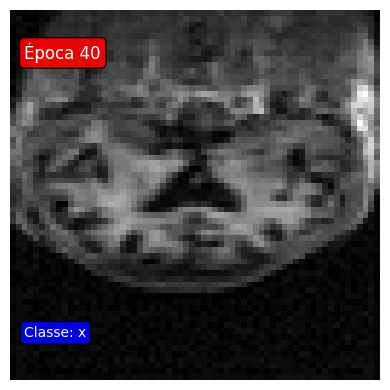

Época 42:   0%|          | 0/61 [00:00<?, ?it/s]

Época 43:   0%|          | 0/61 [00:00<?, ?it/s]

Época 44:   0%|          | 0/61 [00:00<?, ?it/s]

Época 45:   0%|          | 0/61 [00:00<?, ?it/s]

Época 46:   0%|          | 0/61 [00:00<?, ?it/s]

Época 47:   0%|          | 0/61 [00:00<?, ?it/s]

Época 48:   0%|          | 0/61 [00:00<?, ?it/s]

Época 49:   0%|          | 0/61 [00:00<?, ?it/s]

Época 50:   0%|          | 0/61 [00:00<?, ?it/s]

Época 51:   0%|          | 0/61 [00:00<?, ?it/s]

Época 50, Perda: 0.0245


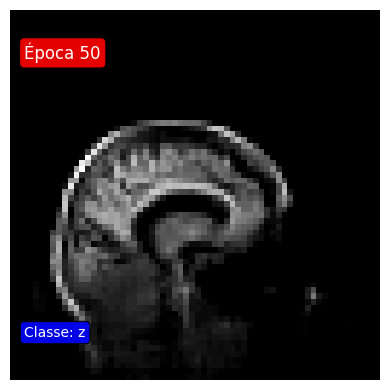

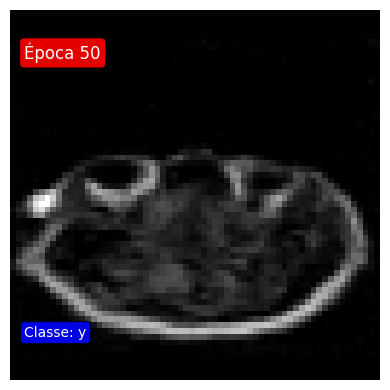

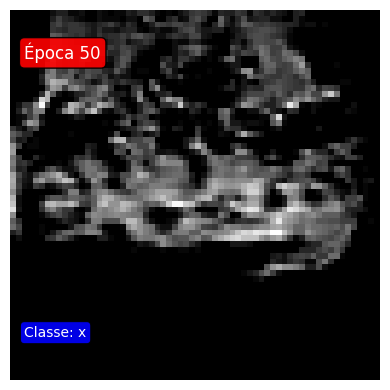

Época 52:   0%|          | 0/61 [00:00<?, ?it/s]

Época 53:   0%|          | 0/61 [00:00<?, ?it/s]

Época 54:   0%|          | 0/61 [00:00<?, ?it/s]

Época 55:   0%|          | 0/61 [00:00<?, ?it/s]

Época 56:   0%|          | 0/61 [00:00<?, ?it/s]

Época 57:   0%|          | 0/61 [00:00<?, ?it/s]

Época 58:   0%|          | 0/61 [00:00<?, ?it/s]

Época 59:   0%|          | 0/61 [00:00<?, ?it/s]

Época 60:   0%|          | 0/61 [00:00<?, ?it/s]

Época 61:   0%|          | 0/61 [00:00<?, ?it/s]

Época 60, Perda: 0.0261


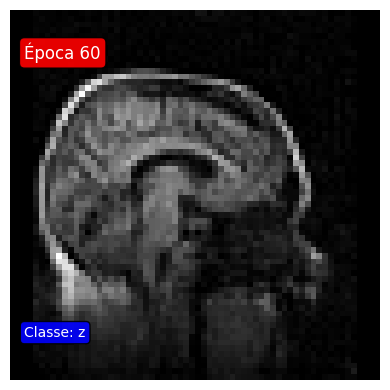

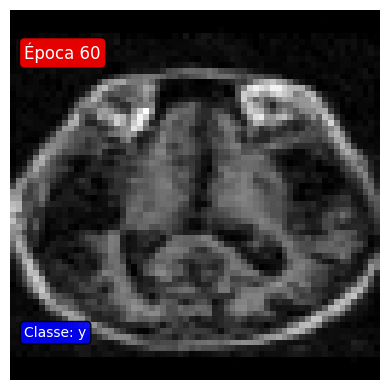

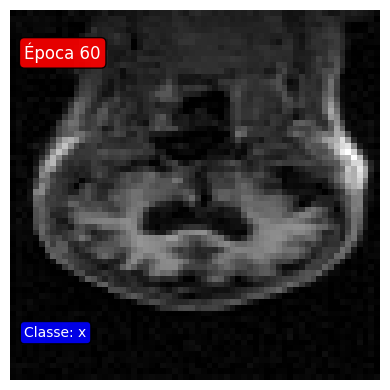

Época 62:   0%|          | 0/61 [00:00<?, ?it/s]

Época 63:   0%|          | 0/61 [00:00<?, ?it/s]

Época 64:   0%|          | 0/61 [00:00<?, ?it/s]

Época 65:   0%|          | 0/61 [00:00<?, ?it/s]

Época 66:   0%|          | 0/61 [00:00<?, ?it/s]

Época 67:   0%|          | 0/61 [00:00<?, ?it/s]

Época 68:   0%|          | 0/61 [00:00<?, ?it/s]

Época 69:   0%|          | 0/61 [00:00<?, ?it/s]

Época 70:   0%|          | 0/61 [00:00<?, ?it/s]

Época 71:   0%|          | 0/61 [00:00<?, ?it/s]

Época 70, Perda: 0.0234


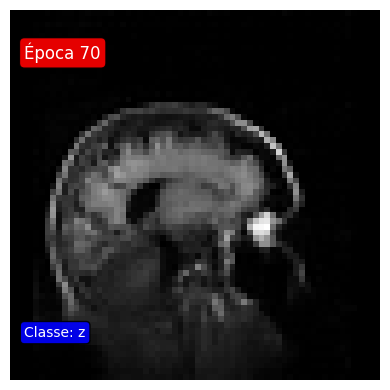

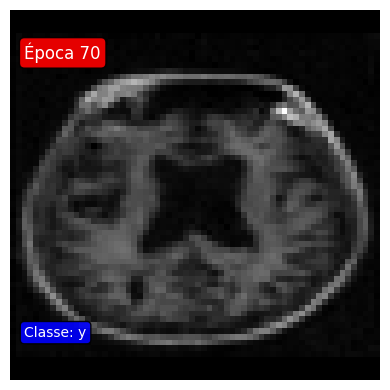

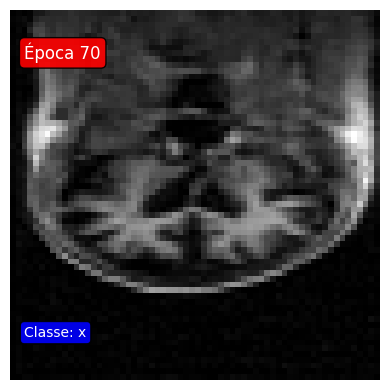

Época 72:   0%|          | 0/61 [00:00<?, ?it/s]

Época 73:   0%|          | 0/61 [00:00<?, ?it/s]

Época 74:   0%|          | 0/61 [00:00<?, ?it/s]

Época 75:   0%|          | 0/61 [00:00<?, ?it/s]

Época 76:   0%|          | 0/61 [00:00<?, ?it/s]

Época 77:   0%|          | 0/61 [00:00<?, ?it/s]

Época 78:   0%|          | 0/61 [00:00<?, ?it/s]

Época 79:   0%|          | 0/61 [00:00<?, ?it/s]

Época 80:   0%|          | 0/61 [00:00<?, ?it/s]

Época 81:   0%|          | 0/61 [00:00<?, ?it/s]

Época 80, Perda: 0.0250


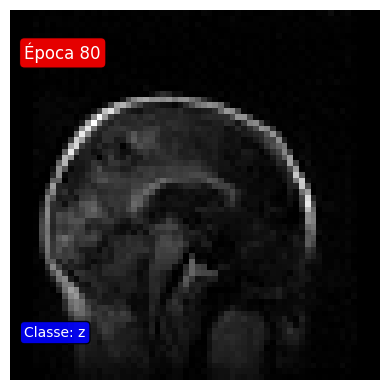

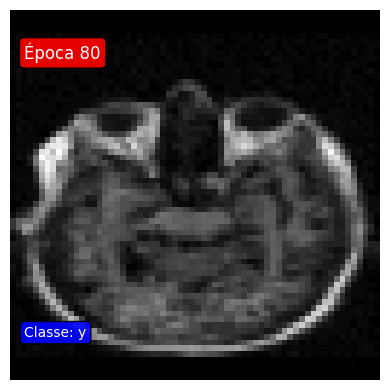

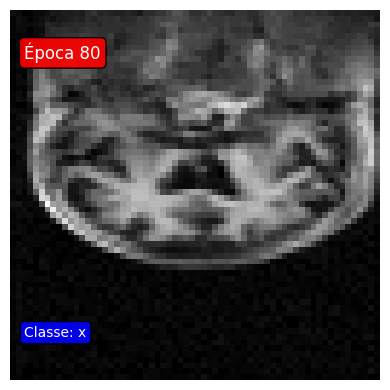

Época 82:   0%|          | 0/61 [00:00<?, ?it/s]

Época 83:   0%|          | 0/61 [00:00<?, ?it/s]

Época 84:   0%|          | 0/61 [00:00<?, ?it/s]

Época 85:   0%|          | 0/61 [00:00<?, ?it/s]

Época 86:   0%|          | 0/61 [00:00<?, ?it/s]

Época 87:   0%|          | 0/61 [00:00<?, ?it/s]

Época 88:   0%|          | 0/61 [00:00<?, ?it/s]

Época 89:   0%|          | 0/61 [00:00<?, ?it/s]

Época 90:   0%|          | 0/61 [00:00<?, ?it/s]

Época 91:   0%|          | 0/61 [00:00<?, ?it/s]

Época 90, Perda: 0.0226


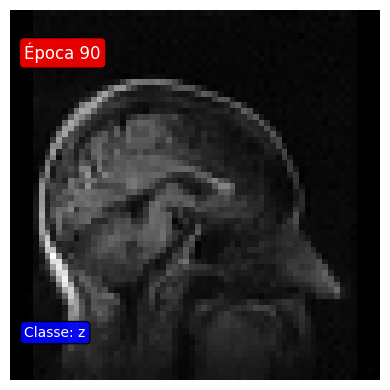

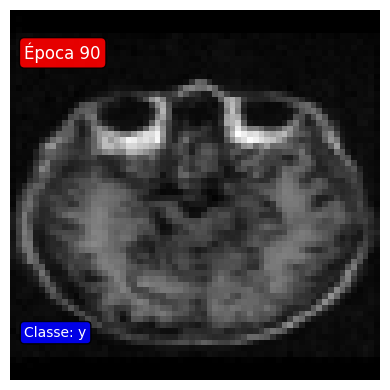

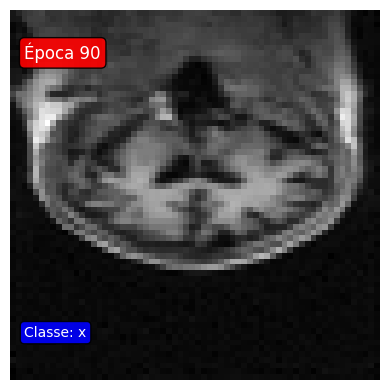

Época 92:   0%|          | 0/61 [00:00<?, ?it/s]

Época 93:   0%|          | 0/61 [00:00<?, ?it/s]

Época 94:   0%|          | 0/61 [00:00<?, ?it/s]

Época 95:   0%|          | 0/61 [00:00<?, ?it/s]

Época 96:   0%|          | 0/61 [00:00<?, ?it/s]

Época 97:   0%|          | 0/61 [00:00<?, ?it/s]

Época 98:   0%|          | 0/61 [00:00<?, ?it/s]

Época 99:   0%|          | 0/61 [00:00<?, ?it/s]

Época 100:   0%|          | 0/61 [00:00<?, ?it/s]

In [ ]:
scaler = GradScaler()

# Parâmetros de treinamento
epochs = 100
print(f"Iniciando treinamento condicional por {epochs} épocas...")

# Lista para salvar frames do progresso
frames = []

model.train()
for epoch in tqdm(range(epochs), desc="Épocas"):
    epoch_loss = 0
    num_batches = 0

    for batch in tqdm(dataloader, desc=f"Época {epoch+1}", leave=False):
        opt.zero_grad()

        # Dados do batch
        x0 = batch['image'].to(device)
        labels = batch['label'].to(device)

        # Timestep aleatório
        t = torch.randint(0, T, (x0.shape[0],), device=device)

        # Treinamento com mixed precision
        with autocast(device_type='cuda'):
            loss = conditional_loss_fn(model, x0, labels, t)

        # Backward pass
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        epoch_loss += loss.item()
        num_batches += 1

    # Logging da perda
    avg_loss = epoch_loss / num_batches

    # Visualização a cada 10 épocas
    if epoch % 10 == 0:
        print(f"Época {epoch}, Perda: {avg_loss:.4f}")

        with torch.no_grad():
            test_class = [0, 1, 2]
            frame_list = []

            for classe in test_class:
                test_labels = torch.tensor([int(classe)], device=device)
                frame = show_and_predict_conditional(model, test_labels, T, epoch)
                frame_list.append(frame)  # Armazena cada imagem individual

            # Concatenar horizontalmente
            concatenated_frame = np.concatenate(frame_list, axis=1)
            frames.append(concatenated_frame)

A criação de GIFs de progresso nos permite observar visualmente como o modelo aprende a associar cada classe com padrões visuais específicos, uma capacidade que não existia em nossas implementações anteriores.

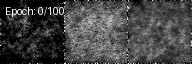

In [ ]:
normalized_frames = []

font = ImageFont.load_default()

for id, frame in enumerate(frames):
    img_array = np.array(frame)

    img_array = np.repeat(img_array, 3, axis=2)

    img_pil = Image.fromarray(img_array.astype(np.uint8))
    draw = ImageDraw.Draw(img_pil)

    acc_text = f"Epoch: {id*10}/{epochs}"
    draw.text((5, 5), acc_text, font=font, fill=(255, 255, 255))

    normalized_frames.append(np.array(img_pil))

# Salvar o GIF
imageio.mimsave("training_process.gif", normalized_frames, fps=2, loop=0)

# Visualização no notebook (se estiver usando IPython/Jupyter)
from IPython.display import Image as Im2
Im2(filename="training_process.gif", width=500)

Agora vamos realizar a inferência do modelo, gerando 6 imagens por classe e visualizando a construção das imagens por meio de GIFs.

In [ ]:
# Gerar GIF do processo de difusão condicional com steps
def generate_conditional_diffusion_gif(model, test_class):
    frames = []

    # Gerar múltiplas amostras da mesma classe
    num_samples = 6
    test_labels = torch.tensor([test_class] * num_samples, device=device)

    # Gerar amostras condicionais
    x = torch.randn(num_samples, 1, img_size, img_size, device=device)

    # Executar processo reverso
    for t in reversed(range(T)):
        x = p_sample_conditional(model, x, t, test_labels, guidance_scale=3.0)

        # Salvar frame a cada 50 steps
        if t % 50 == 0 or t < 5:
            # Lista de imagens individuais
            imgs = [im.cpu().detach() for im in x]

            # Criar separação entre as imagens
            pad = torch.ones((1, img_size, 2))  # (C, H, W)

            # Intercalar imagens e padding
            concat_list = []
            for i, img in enumerate(imgs):
                concat_list.append(img)
                if i < len(imgs) - 1:
                    concat_list.append(pad)

            # Empilhar horizontalmente
            img_grid = torch.cat(concat_list, dim=2).permute(1, 2, 0)
            img_grid = (img_grid.clamp(-1, 1) + 1) / 2  # [0,1]
            img_grid = (img_grid.numpy() * 255).astype('uint8')
            frames.append(img_grid)

    # Criar GIF
    normalized_frames = []
    for frame in frames:
        img_array = np.array(frame)
        img_array = np.concatenate([img_array] * 3, axis=2)
        normalized_frames.append(img_array)

    class_name = dataset.idx_to_label[test_class]
    filename = f"conditional_diffusion_process_{class_name}.gif"
    imageio.mimsave(filename, normalized_frames, fps=4, loop=0)

    print(f"GIF do processo de difusão condicional salvo: {filename}")
    return Im2(filename=filename, width=700)

GIF do processo de difusão condicional salvo: conditional_diffusion_process_z.gif


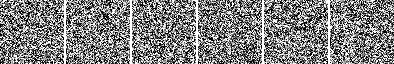

In [ ]:
# Executar para uma classe 0
conditional_diffusion_gif = generate_conditional_diffusion_gif(model, test_class=0)
conditional_diffusion_gif

GIF do processo de difusão condicional salvo: conditional_diffusion_process_y.gif


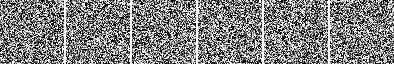

In [ ]:
# Executar para uma classe 1
conditional_diffusion_gif = generate_conditional_diffusion_gif(model, test_class=1)
conditional_diffusion_gif

GIF do processo de difusão condicional salvo: conditional_diffusion_process_x.gif


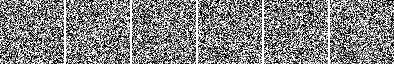

In [ ]:
# Executar para uma classe 2
conditional_diffusion_gif = generate_conditional_diffusion_gif(model, test_class=2)
conditional_diffusion_gif

Além disso também irelos implementar uma função para analisar o progresso por meio snapshots em timesteps específicos, revelando como diferentes características da imagem emergem em momentos distintos do processo reverso.

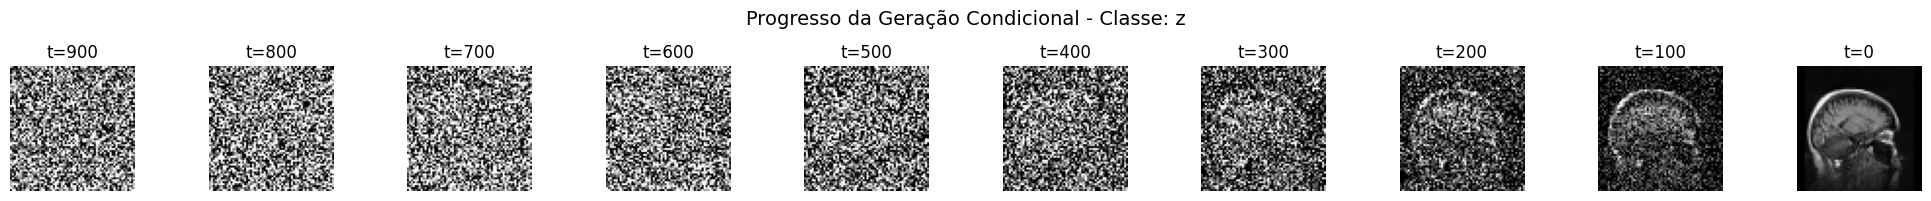

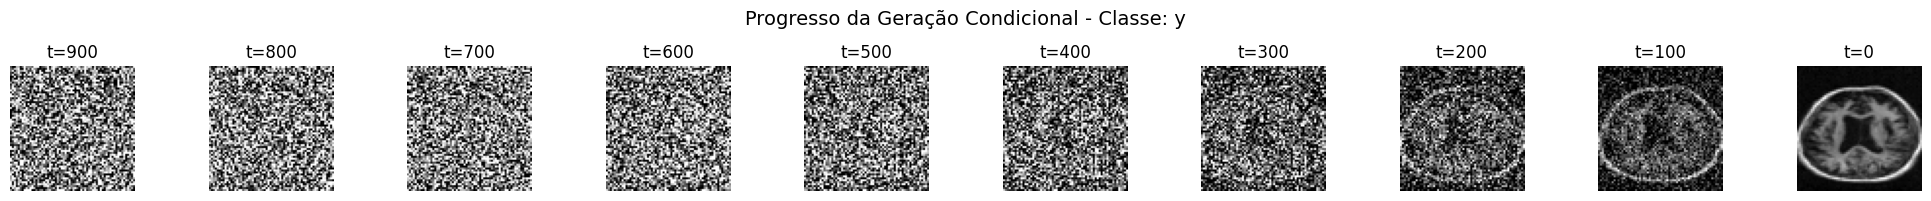

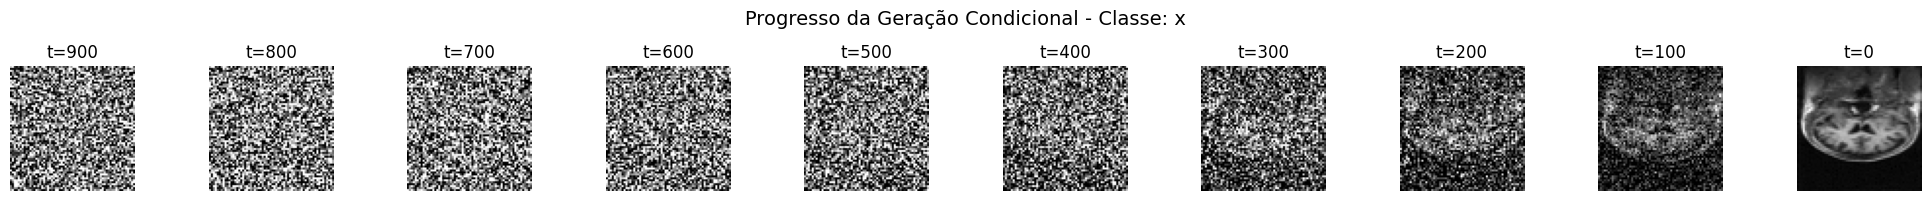

In [ ]:
# Gerar imagens ao longo do tempo t para análise
def analyze_conditional_progress(model, test_class):
    """Analisa o progresso da geração condicional ao longo do tempo"""
    test_labels = torch.tensor([test_class], device=device)

    # Gerar nova imagem de puro ruído
    x = torch.randn(1, 1, img_size, img_size, device=device)

    imgs_over_time = []
    time_steps = []

    for t in reversed(range(0, T)):
        x = p_sample_conditional(model, x, t, test_labels, guidance_scale=3.0)

        # Salvar snapshots a cada 100 steps
        if t % 100 == 0 or t == 0:
            img_vis = (x.clamp(-1, 1) + 1) / 2  # [-1,1] -> [0,1]
            imgs_over_time.append(img_vis[0].detach().cpu())
            time_steps.append(t)

    # Visualizar progresso
    fig, axs = plt.subplots(1, len(imgs_over_time), figsize=(2*len(imgs_over_time), 2))

    for i, (img, t) in enumerate(zip(imgs_over_time, time_steps)):
        if len(imgs_over_time) == 1:
            ax = axs
        else:
            ax = axs[i]

        ax.imshow(img.permute(1, 2, 0).numpy(), cmap='gray')
        ax.axis('off')
        ax.set_title(f"t={t}")

    class_name = dataset.idx_to_label[test_class]
    plt.suptitle(f'Progresso da Geração Condicional - Classe: {class_name}', fontsize=14)
    plt.tight_layout()
    plt.show()

    return imgs_over_time

# Executar análise

test_classes = [0, 1, 2]
for classe in test_classes:
    final_progress = analyze_conditional_progress(model, test_class=classe)